## Чтение файла и запись в переменную *templates*

In [1]:
import json

with open('_vg_85_bgg5jsons 2/0/30_cl.json') as f:
    templates = json.load(f)
templates.keys()

dict_keys(['put_cargos', 'cargo_space', 'cargo_groups', 'timeout_params', 'calculation_params'])

### Вывод информации о грузе, как пример ключей в словаре

In [2]:
templates['cargo_groups'][0]

{'id': '12043Y1',
 'mass': 1832,
 'size': [230, 230, 380],
 'sort': 1,
 'count': 1,
 'stacking': True,
 'turnover': False,
 'overhang_angle': 50,
 'stacking_limit': 0,
 'stacking_is_limited': False,
 'group_id': '4561038K1'}

### Пример подсчета общей массы груза в граммах

In [3]:
mass = 0
for i in templates['cargo_groups']:
    mass += i['mass']*i['count']
mass

71000

# Класс RectangularCuboid, основной класс для создания объекта коробки.

In [184]:
class RectangularCuboid:
    # Конструктор
    def __init__(self, number,sizes):
        # Дефолтные координаты объекта равны None(null)
        # upd - новый способ хранить центр
        self.center = {'x' : None, 'y' : None, 'z' : None}
        # Ориентация может принимать значения от 0 до 5(картинка в беседе)
        self.orientation = 0
        self.points = {"P1" : None, "P2" : None, "P3" : None, "P4" : None, "P5" : None, "P6" : None, "P7" : None, "P8" : None}
        # Словарь координат
        self.cords = {'x_min' : None, 'x_max' : None, 'y_min' : None, 'y_max' : None, 'z_min' : None, 'z_max' : None}
        # Словарь узлов для каждой поверхности
        self.nodes = {"front" : None, "right" : None, "back" : None, "left" : None,  "up" : None, "down" : None}
        # Нумерование коробки
        self.number = number
        # Обработка sizes, можно прям из json закидывать, понимает как словарь, так и список. Все измерения сразу в метрах
        if isinstance(sizes, dict):
            self.size = {'width' : sizes['width']/1000, "height" : sizes['height']/1000, "length" : sizes['length']/1000}
        else:
            self.size = {'width' : sizes[0]/1000, "height" : sizes[1]/1000, "length" : sizes[2]/1000}
        # Объем в м^3
        self.volume = self.size['width']*self.size['height']*self.size['length']
        # Словарь площадей по всем трем плоскостям
        self.square = {'xz_square' : self.size['width']*self.size['length'], 'xy_square' : self.size['height']*self.size['length'], 'yz_square' : self.size['height']*self.size['width']}
        # Значения по умолчанию для переменных ориентирования
        self.size_orientated = {'width' : self.size['width'], "height" : self.size['height'], "length" : self.size['length']}
        self.square_orientated = self.square

        self.max_square_orientated = 0
        self.id_square_orientated = ''
        for k,v in self.square_orientated.items():
            if v > self.max_square_orientated:
                self.id_square_orientated = k
                self.max_square_orientated = v

    # Функция ориентирования в пространстве, запись происходит в другие переменные с постфиксом _orientated
    # Square_orientated хранит ориентированные площади после изменение ориентации
    def orient_box(self, orient):
        self.orientation = orient
        if orient == 0:
            self.size_orientated = {'width' : self.size['width'], "height" : self.size['height'], "length" : self.size['length']}
        if orient == 1:
            self.size_orientated = {'width' : self.size['length'], "height" : self.size['height'], "length" : self.size['width']}
        if orient == 2:
            self.size_orientated = {'width' : self.size['height'], "height" : self.size['width'], "length" : self.size['length']}
        if orient == 3:
            self.size_orientated = {'width' : self.size['length'], "height" : self.size['width'], "length" : self.size['height']}
        if orient == 4:
            self.size_orientated = {'width' : self.size['height'], "height" : self.size['length'], "length" : self.size['width']}
        if orient == 5:
            self.size_orientated = {'width' : self.size['width'], "height" : self.size['length'], "length" : self.size['height']}
        self.square_orientated = {'xz_square' : self.size_orientated['width']*self.size_orientated['length'], 'xy_square' : self.size_orientated['height']*self.size_orientated['length'], 'yz_square' : self.size_orientated['height']*self.size_orientated['width']}
        for k,v in self.square_orientated.items():
            if v > self.max_square_orientated:
                self.id_square_orientated = k
                self.max_square_orientated = v



    # Установка координат центра, также минимальные и максимальные значения по всем осям
    def set_center(self, cord):
        self.center['x'] = cord['x']
        self.center['y'] = cord['y']
        self.center['z'] = cord['z']
        self.cords['x_min'] = self.center['x'] - self.size_orientated['length']/2
        self.cords['x_max'] = self.center['x'] + self.size_orientated['length']/2
        self.cords['y_min'] = self.center['y'] - self.size_orientated['height']/2
        self.cords['y_max'] = self.center['y'] + self.size_orientated['height']/2
        self.cords['z_min'] = self.center['z'] - self.size_orientated['width']/2
        self.cords['z_max'] = self.center['z'] + self.size_orientated['width']/2
        # 8 Крайних точек, снизу вверх по часовой стрелке.
        self.points['P1'] = [self.cords['x_min'], self.cords['y_min'], self.cords['z_min']]
        self.points['P2'] = [self.cords['x_max'], self.cords['y_min'], self.cords['z_min']]
        self.points['P3'] = [self.cords['x_max'], self.cords['y_min'], self.cords['z_max']]
        self.points['P4'] = [self.cords['x_min'], self.cords['y_min'], self.cords['z_max']]

        self.points['P5'] = [self.cords['x_min'], self.cords['y_max'], self.cords['z_min']]
        self.points['P6'] = [self.cords['x_max'], self.cords['y_max'], self.cords['z_min']]
        self.points['P7'] = [self.cords['x_max'], self.cords['y_max'], self.cords['z_max']]
        self.points['P8'] = [self.cords['x_min'], self.cords['y_max'], self.cords['z_max']]

    # Новая функция посмотреть на алгоритм и возможно доработать, проверка коробок реализовано ниже.
    def check_nodes(self, pallet):
        #front node line
        # if self.nodes['front'] is None:
            # print('front' + str(self.size_orientated['width']/2 + self.center['z']))
        if self.size_orientated['width']/2 + self.center['z'] == pallet['width']:
            self.nodes['front'] = None
        else:
                # еще должна быть проверка на постановку рядом с другими коробками
                # self.nodes['front'] = {'z' : self.size_orientated['width']/2 + self.center['z']}
            self.nodes['front'] = {'z' : self.cords['z_max']}
        #back node line
        # if self.nodes['back'] is None:
            # print('back' + str(self.center['z'] - self.size_orientated['width']/2))
        if self.center['z'] - self.size_orientated['width']/2 == 0:
            self.nodes['back'] = None
        else:
                # еще должна быть проверка на постановку рядом с другими коробками
            self.nodes['back'] = {'z' : self.center['z'] - self.size_orientated['width']/2}

        #left node line
        # if self.nodes['left'] is None:
            # print('left' + str(self.center['x'] - self.size_orientated['length']/2))
        if self.center['x'] - self.size_orientated['length']/2 == 0:
             self.nodes['left'] = None
        else:
                # еще должна быть проверка на постановку рядом с другими коробками
            self.nodes['left'] = {'x' : self.center['x'] - self.size_orientated['length']/2}

        #right node line
        # if self.nodes['right'] is None:
            # print('right' + str(self.center['x'] - self.size_orientated['length']/2))
        if self.center['x'] + self.size_orientated['length']/2 == pallet['length']:
            self.nodes['right'] = None
        else:
                # еще должна быть проверка на постановку рядом с другими коробками
                # self.nodes['right'] = {'x' : self.center['x'] + self.size_orientated['length']/2}
            self.nodes['right'] = {'x' : self.cords['x_max']}
        # up node line
        # if self.nodes['up'] is None:
            # print('up' + str(self.center['y'] + self.size_orientated['height']/2))
        if self.center['y'] + self.size_orientated['height']/2 == pallet['height']:
            self.nodes['up'] = None
        else:
            self.nodes['up'] = {'y' : self.center['y'] + self.size_orientated['height']/2}

        # down node line
        # if self.nodes['down'] is None:
            # print('down' + str(self.center['y'] - self.size_orientated['height']/2))
            # ну вообще не может быть снизу место, нужно разобраться
        if self.center['y'] - self.size_orientated['height']/2 == 0:
            self.nodes['down'] = None
        else:
            self.nodes['down'] = {'y' : self.center['y'] - self.size_orientated['height']/2}

    # Возвращает информацию обо всех переменных в виде словаря
    def get_info(self):
        info_dict = {"number" : self.number, "volume":self.volume, "square" : self.square, "size" : self.size, "orientation" : self.orientation, "size_orientated" : self.size_orientated, "square_orientated" : self.square_orientated, "center_coords" : self.center, "nodes" : self.nodes, "cords_min_max" : self.cords, "points" : self.points}
        return info_dict
# def set_coords(box, coords, pallet, default_place = -1):
#     if default_place == -1:
#         check_possible_place()

# def check_possible_place(list_box, box, pallet):

# Пример создания объекта класса и вывода информации.
x = RectangularCuboid(0,templates['cargo_groups'][0]['size'])
x.get_info()

{'number': 0,
 'volume': 0.020102000000000002,
 'square': {'xz_square': 0.0874, 'xy_square': 0.0874, 'yz_square': 0.0529},
 'size': {'width': 0.23, 'height': 0.23, 'length': 0.38},
 'orientation': 0,
 'size_orientated': {'width': 0.23, 'height': 0.23, 'length': 0.38},
 'square_orientated': {'xz_square': 0.0874,
  'xy_square': 0.0874,
  'yz_square': 0.0529},
 'center_coords': {'x': None, 'y': None, 'z': None},
 'nodes': {'front': None,
  'right': None,
  'back': None,
  'left': None,
  'up': None,
  'down': None},
 'cords_min_max': {'x_min': None,
  'x_max': None,
  'y_min': None,
  'y_max': None,
  'z_min': None,
  'z_max': None},
 'points': {'P1': None,
  'P2': None,
  'P3': None,
  'P4': None,
  'P5': None,
  'P6': None,
  'P7': None,
  'P8': None}}

## Создаем словарь с объектами для каждой коробки

In [185]:
counter = 0
all_RectCuboid = []
for i in templates['cargo_groups']:
    for j in range(i['count']):
        all_RectCuboid.append(RectangularCuboid(counter, i['size']))
        counter+=1

### Словарь для хранения размеров паллет

In [186]:
space = dict(zip(['width','height','length'],[templates['cargo_space']['size'][0]/1000, templates['cargo_space']['size'][1]/1000, templates['cargo_space']['size'][2]/1000]))
space


{'width': 1.25, 'height': 2.1, 'length': 1.8}

## Функция рандома координат, возвращает словарь, не вываливается за границы паллета

In [176]:
import random
def random_center(pallet_size, box_size):
    center_rand = {'x': random.randint(int(box_size['length'] * 1000 / 2), int(pallet_size['length'] * 1000 - box_size['length']*1000 / 2)) / 1000,
                   'y': random.randint(int(box_size['height'] * 1000 / 2), int(pallet_size['height'] * 1000 - box_size['height']*1000 / 2)) / 1000,
                   'z': random.randint(int(box_size['width'] * 1000 / 2), int(pallet_size['width'] * 1000 - box_size['width']*1000 / 2)) / 1000}
    return center_rand

## Проверка на возможность размещения коробки в паллете, на основе данных списка с уже имеющимися коробками

In [177]:
def check_box_placement(list_boxes, box):
    for boxes in list_boxes:
        if box.cords['x_min'] < boxes.cords['x_max'] and box.cords['x_max'] > boxes.cords['x_min'] and box.cords['y_min'] < boxes.cords['y_max'] and box.cords['y_max'] > boxes.cords['y_min'] and box.cords['z_min'] < boxes.cords['z_max'] and box.cords['z_max'] > boxes.cords['z_min']:
            return False
    return True


## Тест рандома, 10000 раз, пытаемся поставить коробку 300 раз. Вывод - количество установленных коробок, время работы алгоритма, также получаем список places со всеми удачными расположениями, place - одно расположение, список result по каждой итерации количество установленных коробок.

In [116]:
# Placement 1 box
result = []
place = []
places = []
import time
start = time.time()
for i in range(1000):
    test_Placement = []
    test = all_RectCuboid[0]
    test.set_center({'x' : test.size_orientated['length']/2, 'y' : test.size_orientated['height']/2, 'z' : test.size_orientated['width']/2})
    test_Placement.append(test)
    flag = False
    ok = True
    for rect in all_RectCuboid[1:]:
        ok = True
        rand_cord = random_center(space, rect.size_orientated)
        rect.set_center(rand_cord)
        for num in range(300):
            if check_box_placement(test_Placement, rect):
                test_Placement.append(rect)
                ok = False
                break
            else:
                rand_cord = random_center(space, rect.size_orientated)
                rect.set_center(rand_cord)
        if ok:
            break
    if result and len(test_Placement) > max(result):
        place = test_Placement
    elif result and len(test_Placement) == max(result):
        place = test_Placement
        places.append(test_Placement)
    result.append(len(test_Placement))
print(max(result))
print(time.time() - start)

39
8.837788105010986


placed
placed
placed
placed
placed
placed
placed
placed
placed
done
10


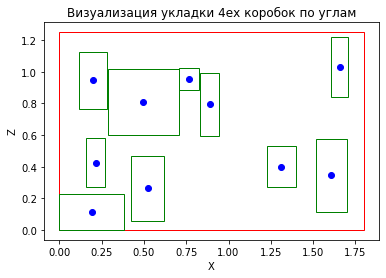

In [193]:
# Placement 1 box
result = []
place = []
places = []
import time
start = time.time()
test_Placement = []
test = all_RectCuboid[0]
test.set_center({'x' : test.size_orientated['length']/2, 'y' : test.size_orientated['height']/2, 'z' : test.size_orientated['width']/2})
test_Placement.append(test)
flag = False
ok = True
for rect in all_RectCuboid[1:]:
    ok = True
    rand_cord = random_center(space, rect.size_orientated)
    rand_cord['y'] = rect.size_orientated['height']/2
    rect.set_center(rand_cord)
    for num in range(10000):
        if check_box_placement(test_Placement, rect):
            test_Placement.append(rect)
            print('placed')
            ok = False
            break
        else:
            rand_cord = random_center(space, rect.size_orientated)
            rand_cord['y'] = rect.size_orientated['height']/2
            rect.set_center(rand_cord)
    if ok:
        print('done')
        break
print(len(test_Placement))
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots()
space_rect = patches.Rectangle((0,0), space['length'], space['width'], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(space_rect)
for obj in test_Placement:
    x1 = obj.center['x']
    z1 = obj.center['z']
    ax.plot(x1,z1, 'o', color='blue')
    rect = patches.Rectangle((obj.cords['x_min'], obj.cords['z_min']), obj.size_orientated['length'], obj.size_orientated['width'], linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_title('Визуализация укладки 4ех коробок по углам')
plt.savefig('4.png', dpi=300)
# for i in test_Placement:
#     print(i.get_info())
# if result and len(test_Placement) > max(result):
#     place = test_Placement
# elif result and len(test_Placement) == max(result):
#     place = test_Placement
#     places.append(test_Placement)
#     result.append(len(test_Placement))

# print(max(result))
# print(time.time() - start)

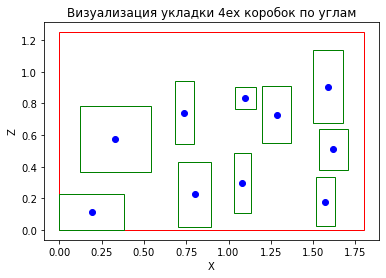

In [192]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots()
space_rect = patches.Rectangle((0,0), space['length'], space['width'], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(space_rect)
for obj in test_Placement:
    x1 = obj.center['x']
    z1 = obj.center['z']
    ax.plot(x1,z1, 'o', color='blue')
    rect = patches.Rectangle((obj.cords['x_min'], obj.cords['z_min']), obj.size_orientated['length'], obj.size_orientated['width'], linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_title('Визуализация укладки 4ех коробок по углам')
plt.savefig('4.png', dpi=300)

### Полное количество коробок в списке (исходном)

In [10]:
print(len(all_RectCuboid))

57


### Занятый объем коробками и полный объем паллета

In [11]:
sum_vol = 0
for pl in place:
    sum_vol += pl.volume
print(sum_vol)
from functools import reduce
print(reduce((lambda x, y : x*y), list(space.values())))

1.8968619499999997
4.7250000000000005


## Вывод всех координат коробок из place, можно будет посмотреть еще и на другие "удачные укладки" сделав еще один цикл по places.

In [41]:
for pl in place:
    print (pl.center)

In [94]:
import copy
copyAll = copy.deepcopy(all_RectCuboid)
N = len(copyAll)

for i in range(N):
    for j in range(N- i - 1):
        if copyAll[j].max_square_orientated < copyAll[j+1].max_square_orientated :
            copyAll[j] , copyAll[j+1]  = copyAll[j+1] , copyAll[j]
for i in copyAll:
    print(i.max_square_orientated, i.id_square_orientated, i.number)


# Примерный алгоритм заполнения узлов, нужно реализовать функцию!!!

In [40]:
import copy

box1 = copy.deepcopy(all_RectCuboid[0])
box1.set_center({'x' : box1.size_orientated['length']/2, 'y' : box1.size_orientated['height']/2, 'z' : box1.size_orientated['width']/2})
box1.check_nodes(space)
print("BOX1_NODES----------------------------")
print(box1.nodes)
print()
print("BOX1_NODES_AFTER_SET_BOX2NODES--------")
box2 = copy.deepcopy(all_RectCuboid[1])
box2.set_center({'x' : box2.size_orientated['length']/2, 'y' : box2.size_orientated['height']/2, 'z' : box1.nodes['front']['z'] + box2.size_orientated['width']/2})
print(box1.nodes)
print()
print("BOX1_NODES_CHANGE_NODE_TO_NUMBER------")
box1.nodes['front'] = box2.number
print(box1.nodes)
print()
print("BOX2_NODES----------------------------")
box2.check_nodes(space)
print(box2.nodes)
print()
print("BOX2_NODES_CHANGE_NODE_TO_NUMBER------")
box2.nodes['back'] = box1.number
print(box2.nodes)
print("END-----------------------------------")

BOX1_NODES----------------------------
{'front': {'z': 0.23}, 'right': {'x': 0.38}, 'back': None, 'left': None, 'up': {'y': 0.23}, 'down': None}

BOX1_NODES_AFTER_SET_BOX2NODES--------
{'front': {'z': 0.23}, 'right': {'x': 0.38}, 'back': None, 'left': None, 'up': {'y': 0.23}, 'down': None}

BOX1_NODES_CHANGE_NODE_TO_NUMBER------
{'front': 1, 'right': {'x': 0.38}, 'back': None, 'left': None, 'up': {'y': 0.23}, 'down': None}

BOX2_NODES----------------------------
{'front': {'z': 0.5900000000000001}, 'right': {'x': 0.17}, 'back': {'z': 0.23000000000000004}, 'left': None, 'up': {'y': 0.205}, 'down': None}

BOX2_NODES_CHANGE_NODE_TO_NUMBER------
{'front': {'z': 0.5900000000000001}, 'right': {'x': 0.17}, 'back': 0, 'left': None, 'up': {'y': 0.205}, 'down': None}
END-----------------------------------


In [280]:
def place_box(b_1, b_2, node):
    reverse_nodes = {'front' : 'back', 'back' : 'front', 'up' : 'down', 'down' : 'up', 'left' : 'right', 'right' : 'left'}
    b_1.nodes[node] = b_2.number
    b_2.nodes[reverse_nodes[node]] = b_1.number

def check_box_pallet(b, s):
    if b.center['x'] + b.size_orientated['length']/2 <= s['length'] and b.center['y'] + b.size_orientated['height']/2 <= s['height'] and b.center['z'] + b.size_orientated['width']/2 <= s['width']:
        return True
    return False
# НЕ РАБОТАЕТ
def check_hueta(list_boxes, box):
    x_max = 0
    x_min = 10
    z_max = 0
    z_min = 10
    for boxes in list_boxes:
        if box.cords['x_min'] < boxes.cords['x_max'] and box.cords['x_max'] > boxes.cords['x_min'] and box.cords['y_min'] < boxes.cords['y_max'] and box.cords['y_max'] > boxes.cords['y_min'] and box.cords['z_min'] < boxes.cords['z_max'] and box.cords['z_max'] > boxes.cords['z_min']:
            if box.cords['x_min'] < boxes.cords['x_max']:
                if boxes.cords['x_max'] >= x_max:
                    x_max = boxes.cords['x_max']
                # print('x_max',boxes.cords['x_max'])
            if box.cords['x_max'] > boxes.cords['x_min']:
                if boxes.cords['x_min'] <= x_min:
                    x_max = boxes.cords['x_min']
                # print('x_min',boxes.cords['x_min'])
            # if box.cords['y_min'] < boxes.cords['y_max']:
            #     print('y_max', boxes.cords['y_max'])
            # if box.cords['y_max'] > boxes.cords['y_min']:
            #     print('y_min', boxes.cords['y_min'])
            if box.cords['z_min'] < boxes.cords['z_max']:
                if boxes.cords['z_max'] >= z_max:
                    z_max = boxes.cords['z_max']
                # print('z_max', boxes.cords['z_max'])
            if box.cords['z_max'] > boxes.cords['z_min']:
                if boxes.cords['z_min'] <= z_min:
                    z_min = boxes.cords['z_min']
            # print('z_min',  boxes.cords['z_min'])
    if x_max == 0:
        x_max = None
    if x_min == 10:
        x_min = None
    if z_max == 0:
        z_max = None
    if z_min == 10:
        z_min = None
    return [x_max, x_min, z_max, z_min]
    #     if box.cords['x_min'] < boxes.cords['x_max'] and box.cords['x_max'] > boxes.cords['x_min'] and box.cords['y_min'] < boxes.cords['y_max'] and box.cords['y_max'] > boxes.cords['y_min'] and box.cords['z_min'] < boxes.cords['z_max'] and box.cords['z_max'] > boxes.cords['z_min']:
    #         print(box.cords['x_min'] < boxes.cords['x_max'], box.cords['x_max'] > boxes.cords['x_min'], box.cords['y_min'] < boxes.cords['y_max'], box.cords['y_max'] > boxes.cords['y_min'], box.cords['z_min'] < boxes.cords['z_max'], box.cords['z_max'] > boxes.cords['z_min'])
    #         return False
    # return True
test1 = copy.deepcopy(all_RectCuboid)
list_nodes_placed_box = []

test1[0].set_center({'x' : test1[0].size_orientated['length']/2, 'y' : test1[0].size_orientated['height']/2, 'z' : test1[0].size_orientated['width']/2})
test1[0].check_nodes(space)
# print(test1[0].get_info())


list_nodes_placed_box.append(test1[0].nodes)
placed_box_list = [test1[0]]

set_node = ['front', 'right']
cords_node = ['z', 'x']
cnt = 0
row_node = 0
crd_node = 0
for j,i in enumerate(test1[1:]):
    print("ITER" + str(j))
    crd = list_nodes_placed_box[j][set_node[cnt]][cords_node[cnt]]
    i.set_center({'x' : crd_node + i.size_orientated['length']/2, 'y' : i.size_orientated['height']/2, 'z' : crd + i.size_orientated['width']/2})
    i.check_nodes(space)
    print(i.nodes)
    if check_box_placement(placed_box_list, i) and check_box_pallet(i, space):
        print("placed_front")
        place_box(placed_box_list[j], i, set_node[cnt])
        list_nodes_placed_box.append(i.nodes)
        placed_box_list.append(i)
    else:
        print("try right")
        cnt = 1
        crd = list_nodes_placed_box[row_node][set_node[cnt]][cords_node[cnt]]
        print(i.nodes)
        c = check_hueta(placed_box_list, i)
        if c[0] is None and c[1] is None and c[2] is None and c[3] is None:
            c = [0,0,0,0]
        print(c)
        if c[0] is None:
            c[0] = 0
        i.set_center({'x' : c[0] + i.size_orientated['length']/2, 'y' : i.size_orientated['height']/2, 'z' : crd + i.size_orientated['width']/2})
        i.check_nodes(space)
        if check_box_placement(placed_box_list, i) and check_box_pallet(i, space):
            place_box(placed_box_list[j], i, set_node[cnt])
            list_nodes_placed_box.append(i.nodes)
            placed_box_list.append(i)
            row_node = j+1
            print('right')
            cnt = 0
            crd_node = i.cords['x_min']
        else:
            i.set_center({'x' : crd + i.size_orientated['length']/2, 'y' : i.size_orientated['height']/2, 'z' : i.size_orientated['width']/2})
            i.check_nodes(space)
            print(i.nodes)
            if check_box_placement(placed_box_list, i) and check_box_pallet(i, space):
                place_box(placed_box_list[j], i, set_node[cnt])
                list_nodes_placed_box.append(i.nodes)
                placed_box_list.append(i)
                row_node = j+1
                print('right')
                cnt = 0
                crd_node = i.cords['x_min']
            else:
                print(crd + i.size_orientated['length']/2)
                print(c[0])
                print(row_node)
                print(len(list_nodes_placed_box))
                print(check_box_placement(placed_box_list, i), check_box_pallet(i, space))
                print('pizda')
                break
    print("END", i.center, list_nodes_placed_box[j+1])
print(placed_box_list[-1].get_info())

ITER0
{'front': {'z': 0.5900000000000001}, 'right': {'x': 0.17}, 'back': {'z': 0.23000000000000004}, 'left': None, 'up': {'y': 0.205}, 'down': None}
placed_front
END {'x': 0.085, 'y': 0.1025, 'z': 0.41000000000000003} {'front': {'z': 0.5900000000000001}, 'right': {'x': 0.17}, 'back': 0, 'left': None, 'up': {'y': 0.205}, 'down': None}
ITER1
{'front': {'z': 1.01}, 'right': {'x': 0.42}, 'back': {'z': 0.5900000000000001}, 'left': None, 'up': {'y': 0.298}, 'down': None}
placed_front
END {'x': 0.21, 'y': 0.149, 'z': 0.8} {'front': {'z': 1.01}, 'right': {'x': 0.42}, 'back': 1, 'left': None, 'up': {'y': 0.298}, 'down': None}
ITER2
{'front': {'z': 1.4200000000000002}, 'right': {'x': 0.2}, 'back': {'z': 1.01}, 'left': None, 'up': {'y': 0.166}, 'down': None}
try right
{'front': {'z': 1.4200000000000002}, 'right': {'x': 0.2}, 'back': {'z': 1.01}, 'left': None, 'up': {'y': 0.166}, 'down': None}
[0, 0, 0, 0]
{'front': {'z': 0.41}, 'right': {'x': 0.58}, 'back': None, 'left': {'x': 0.38}, 'up': {'y': 

Text(0, 0.5, 'X')

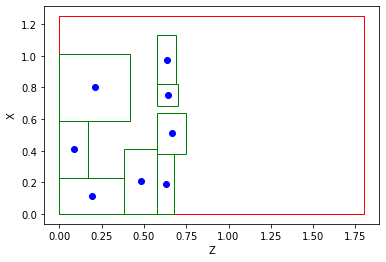

In [281]:
fig, ax = plt.subplots()
space_rect = patches.Rectangle((0,0), space['length'], space['width'], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(space_rect)
for obj in placed_box_list:
    x1 = obj.center['x']
    z1 = obj.center['z']
    ax.plot(x1,z1, 'o', color='blue')
    rect = patches.Rectangle((obj.cords['x_min'], obj.cords['z_min']), obj.size_orientated['length'], obj.size_orientated['width'], linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
ax.set_xlabel('Z')
ax.set_ylabel('X')

# ТЕСТЫ ИСПРАВЛЕННОЙ ВЕРХНЕЙ ЯЧЕЙКИ

In [285]:
def place_box(b_1, b_2, node):
    reverse_nodes = {'front' : 'back', 'back' : 'front', 'up' : 'down', 'down' : 'up', 'left' : 'right', 'right' : 'left'}
    b_1.nodes[node] = b_2.number
    b_2.nodes[reverse_nodes[node]] = b_1.number

def check_box_pallet(b, s):
    if b.center['x'] + b.size_orientated['length']/2 <= s['length'] and b.center['y'] + b.size_orientated['height']/2 <= s['height'] and b.center['z'] + b.size_orientated['width']/2 <= s['width']:
        return True
    return False
# НЕ РАБОТАЕТ
def check_left(list_boxes, box):
    x_max = 0
    for boxes in list_boxes:
        if box.cords['x_min'] < boxes.cords['x_max'] and box.cords['x_max'] > boxes.cords['x_min'] and box.cords['y_min'] < boxes.cords['y_max'] and box.cords['y_max'] > boxes.cords['y_min'] and box.cords['z_min'] < boxes.cords['z_max'] and box.cords['z_max'] > boxes.cords['z_min']:
            if box.cords['x_min'] < boxes.cords['x_max'] < box.cords['x_max']:
                x_max = boxes.cords['x_max'] - box.cords['x_min']

    return x_max
#копирование
test1 = copy.deepcopy(all_RectCuboid)
list_nodes_placed_box = []
# ставим руками коробку
test1[0].set_center({'x' : test1[0].size_orientated['length']/2, 'y' : test1[0].size_orientated['height']/2, 'z' : test1[0].size_orientated['width']/2})
test1[0].check_nodes(space)
list_nodes_placed_box.append(test1[0].nodes)
placed_box_list = [test1[0]]

# test
test1[10].orient_box(3)
# нужная хуйня
set_node = ['front', 'right']
cords_node = ['z', 'x']
cnt = 0
row_node = 0
crd_node = 0
for j,i in enumerate(test1[1:]):
    print("ITER" + str(j))
    #считаем кординату по z, ставим центр и ноды
    crd = list_nodes_placed_box[j][set_node[cnt]][cords_node[cnt]]
    i.set_center({'x' : crd_node + i.size_orientated['length']/2, 'y' : i.size_orientated['height']/2, 'z' : crd + i.size_orientated['width']/2})
    i.check_nodes(space)

    # print(i.nodes)
    # можем ли мы так ее разместить и не вылазим ли за паллет
    if check_box_placement(placed_box_list, i) and check_box_pallet(i, space):
        print("placed_front")
        place_box(placed_box_list[j], i, set_node[cnt])
        list_nodes_placed_box.append(i.nodes)
        placed_box_list.append(i)
    else:
        left = check_left(placed_box_list, i)
        if left != 0:
            print('left kasanie')
            i.set_center({'x' : crd_node + left + i.size_orientated['length']/2, 'y' : i.size_orientated['height']/2, 'z' : crd + i.size_orientated['width']/2})
            i.check_nodes(space)
            if check_box_placement(placed_box_list, i) and check_box_pallet(i, space):
                place_box(placed_box_list[j], i, set_node[cnt])
                list_nodes_placed_box.append(i.nodes)
                placed_box_list.append(i)
                continue
        else:
            print("try right")
            cnt = 1
            print(list_nodes_placed_box[row_node], set_node[cnt], cords_node[cnt])
            crd = list_nodes_placed_box[row_node][set_node[cnt]][cords_node[cnt]]
            i.set_center({'x' : crd + i.size_orientated['length']/2, 'y' : i.size_orientated['height']/2, 'z' : i.size_orientated['width']/2})
            i.check_nodes(space)

        if check_box_placement(placed_box_list, i) and check_box_pallet(i, space):
            place_box(placed_box_list[j], i, set_node[cnt])
            list_nodes_placed_box.append(i.nodes)
            placed_box_list.append(i)
            row_node = j+1
            print('right')
            cnt = 0
            crd_node = i.cords['x_min']
        else:
            i.set_center({'x' : crd + i.size_orientated['length']/2, 'y' : i.size_orientated['height']/2, 'z' : i.size_orientated['width']/2})
            i.check_nodes(space)
            if check_box_placement(placed_box_list, i) and check_box_pallet(i, space):
                place_box(placed_box_list[j], i, set_node[cnt])
                list_nodes_placed_box.append(i.nodes)
                placed_box_list.append(i)
                row_node = j+1
                print('right')
                cnt = 0
                crd_node = i.cords['x_min']
            else:
                print(crd + i.size_orientated['length']/2)
                print(row_node)
                print(crd_node)
                print(len(list_nodes_placed_box))
                print(check_box_placement(placed_box_list, i), check_box_pallet(i, space))
                print('pizda')
                break
    print("END", i.center, list_nodes_placed_box[j+1])
print(placed_box_list[-1].get_info())

ITER0
placed_front
END {'x': 0.085, 'y': 0.1025, 'z': 0.41000000000000003} {'front': {'z': 0.5900000000000001}, 'right': {'x': 0.17}, 'back': 0, 'left': None, 'up': {'y': 0.205}, 'down': None}
ITER1
placed_front
END {'x': 0.21, 'y': 0.149, 'z': 0.8} {'front': {'z': 1.01}, 'right': {'x': 0.42}, 'back': 1, 'left': None, 'up': {'y': 0.298}, 'down': None}
ITER2
try right
{'front': 1, 'right': {'x': 0.38}, 'back': None, 'left': None, 'up': {'y': 0.23}, 'down': None} right x
right
END {'x': 0.48, 'y': 0.083, 'z': 0.205} {'front': {'z': 0.41}, 'right': {'x': 0.58}, 'back': None, 'left': 2, 'up': {'y': 0.166}, 'down': None}
ITER3
left kasanie
ITER4
left kasanie
ITER5
placed_front
END {'x': 0.44, 'y': 0.079, 'z': 1.12} {'front': {'z': 1.1900000000000002}, 'right': {'x': 0.5}, 'back': 5, 'left': {'x': 0.38}, 'up': {'y': 0.158}, 'down': None}
ITER6
try right
{'front': 4, 'right': {'x': 0.58}, 'back': None, 'left': 2, 'up': {'y': 0.166}, 'down': None} right x
right
END {'x': 0.635, 'y': 0.0805, 'z

Text(0, 0.5, 'X')

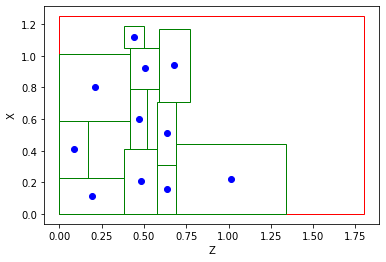

In [286]:
fig, ax = plt.subplots()
space_rect = patches.Rectangle((0, 0), space['length'], space['width'], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(space_rect)
for obj in placed_box_list:
    x1 = obj.center['x']
    z1 = obj.center['z']
    ax.plot(x1, z1, 'o', color='blue')
    rect = patches.Rectangle((obj.cords['x_min'], obj.cords['z_min']), obj.size_orientated['length'],
                             obj.size_orientated['width'], linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
ax.set_xlabel('Z')
ax.set_ylabel('X')

In [268]:
print(list_nodes_placed_box[-1], placed_box_list[-1].number)

{'front': {'z': 1.11}, 'right': {'x': 0.52}, 'back': 7, 'left': {'x': 0.41}, 'up': {'y': 0.169}, 'down': None} 8


### Пример задания координат и создания списка уложенных коробок

In [7]:
RectCuboid = []

# xzy
sample_cords = [{'x' : 0,'z' : 0,'y' : 0}, {'x' : space['length'], 'z' : 0,'y' : 0}, {'x' : 0, 'y' : 0, 'z' : space['width']}, {'x' : space['length'], 'y':0, 'z' : space['width']}]
#Это можно взять за основу проверки на выход за границы
for i in range(4):
    tmp_dict = {}
    temp = all_RectCuboid[i]
    if sample_cords[i]['x'] + temp.size_orientated['length']/2 > space['length']:
        tmp_dict['x'] = space['length'] - temp.size_orientated['length']/2
    else:
        tmp_dict['x'] = sample_cords[i]['x'] + temp.size_orientated['length']/2

    if sample_cords[i]['y'] + temp.size_orientated['height']/2 > space['height']:
        tmp_dict['y'] = space['height'] - temp.size_orientated['height']/2
    else:
        tmp_dict['y'] = sample_cords[i]['y'] + temp.size_orientated['height']/2

    if sample_cords[i]['z'] + temp.size_orientated['width']/2 > space['width']:
        tmp_dict['z'] = space['width'] - temp.size_orientated['width']/2
    else:
        tmp_dict['z'] = sample_cords[i]['z'] + temp.size_orientated['width']/2
    temp.set_center(tmp_dict)
    RectCuboid.append(temp)
# def checker(list_cubes, box, coords):
#
#     for i in list_cubes:


### График уложенных коробок в осях XZ

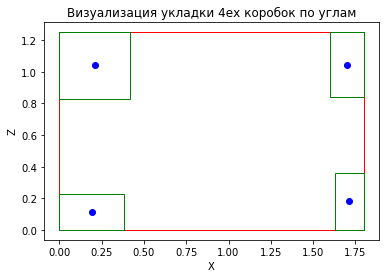

In [8]:
# plot
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots()
space_rect = patches.Rectangle((0,0), space['length'], space['width'], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(space_rect)
for obj in RectCuboid:
    x1 = obj.center['x']
    z1 = obj.center['z']
    ax.plot(x1,z1, 'o', color='blue')
    rect = patches.Rectangle((obj.cords['x_min'], obj.cords['z_min']), obj.size_orientated['length'], obj.size_orientated['width'], linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_title('Визуализация укладки 4ех коробок по углам')
plt.savefig('4_box_corners.png', dpi=300)

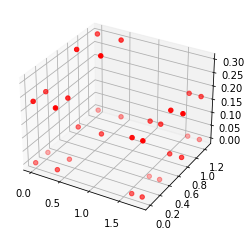

In [14]:
#Пока не очень в 3д, не научился рисовать плоскости, но по точкам можно понять коробки в 4ех углах
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for obj in RectCuboid:
    ax.scatter([i[0] for i in list(obj.points.values())],[i[2] for i in list(obj.points.values())],[i[1] for i in list(obj.points.values())],c='red',marker='o')
plt.show()

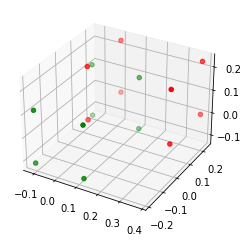

In [13]:
# Нужно доработать определение границ, но разворот работает)))
import copy
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
b = copy.deepcopy(RectCuboid[0])
b1 = copy.deepcopy(RectCuboid[0])
b1.orient_box(1)
b1.set_center({'x' : 0, 'y' : 0, 'z' : 0})
ax1.scatter([i[0] for i in list(b.points.values())],[i[2] for i in list(b.points.values())],[i[1] for i in list(b.points.values())],c='red')
ax1.scatter([i[0] for i in list(b1.points.values())],[i[2] for i in list(b1.points.values())],[i[1] for i in list(b1.points.values())],c='green')
plt.show()

# Код для создания изображений графиков для всех файлов и типов коробок в них

In [ ]:
import os.path
import matplotlib.pylab as plt
for address, dirs, files in os.walk('./_vg_85_bgg5jsons 2/'):
    for name in files:
        print(os.path.join(address, name))
        pa = os.path.join(address, name)
        if pa == './_vg_85_bgg5jsons 2/.DS_Store':
            continue
        else:
            with open(pa) as f:
                templates = json.load(f)
            volume = {}
            # print(templates['cargo_groups'][0]['size'])
            if isinstance(templates['cargo_groups'][0]['size'], dict):
                for j,i in enumerate(templates['cargo_groups']):
                    volume[j] = i['size']['width']*i['size']['height']*i['size']['length']/1000000000
            else:
                for j,i in enumerate(templates['cargo_groups']):
                    volume[j] = i['size'][0]*i['size'][1]*i['size'][2]/1000000000

            lists = sorted(volume.items())
            x, y = zip(*lists)
            plt.bar(x, y)
            plt.savefig('./test_dir/'+name.split('.')[0]+'.png')
            plt.clf()
            plt.close()
            f.close()

# Код для поиска информации из всех json

In [ ]:
# Код для Parsing всех json
import os.path
json_list = []
for address, dirs, files in os.walk('./_vg_85_bgg5jsons 2/'):
    for name in files:
        # print(os.path.join(address, name))
        pa = os.path.join(address, name)
        if pa == './_vg_85_bgg5jsons 2/.DS_Store':
            continue
        else:
            with open(pa) as f:
                templates = json.load(f)
            #Переменные для объемов и размеров
            volume_dict = {}
            volume_sum = 0
            sizes_dict = {}
            #Обработка size для групп коробок, может быть как лист так и словарь
            if isinstance(templates['cargo_groups'][0]['size'], dict):
                for j,i in enumerate(templates['cargo_groups']):
                    volume_dict[j] = i['size']['width']*i['size']['height']*i['size']['length']/1000000000
                    volume_sum+= i['size']['width']*i['size']['height']*i['size']['length']/1000000000 * i['count']
                    sizes_dict[j] = i['size']
            else:
                for j,i in enumerate(templates['cargo_groups']):
                    volume_dict[j] = i['size'][0]*i['size'][1]*i['size'][2]/1000000000
                    volume_sum+= i['size'][0]*i['size'][1]*i['size'][2]/1000000000 * i['count']
                    sizes_dict[j] = {'width' : i['size'][0], 'height': i['size'][1], 'length': i['size'][2]}
                    
            #Аналогично с размером палета
            if isinstance(templates['cargo_space']['size'], dict):
                volume_cargo = templates['cargo_space']['size']['width']*templates['cargo_space']['size']['height']*templates['cargo_space']['size']['length']/1000000000
            else:
                volume_cargo = templates['cargo_space']['size'][0]*templates['cargo_space']['size'][1]*templates['cargo_space']['size'][2]/1000000000
            # Подсчет процента
            volume_percent = volume_sum/volume_cargo
            # Теперь размеры минимальные и максимальные по каждому измерению
            values_dict = {}
            for i, j in sizes_dict.items():
                if not values_dict:
                    values_dict['width_min'] = {i : j['width']}
                    values_dict['height_min'] = {i : j['height']}
                    values_dict['length_min'] = {i : j['height']}
                    values_dict['width_max'] = {i : j['width']}
                    values_dict['height_max'] = {i : j['height']}
                    values_dict['length_max'] = {i : j['height']}
                else:
                    if j['width'] > list(values_dict['width_max'].values())[0]:
                        values_dict['width_max'] = {i : j['width']}
                    if j['height'] > list(values_dict['height_max'].values())[0]:
                        values_dict['height_max'] = {i : j['height']}
                    if j['length'] > list(values_dict['length_max'].values())[0]:
                        values_dict['length_max'] = {i : j['length']}
                        
                    if j['width'] < list(values_dict['width_min'].values())[0]:
                        values_dict['width_min'] = {i : j['width']}
                    if j['height'] < list(values_dict['height_min'].values())[0]:
                        values_dict['height_min'] = {i : j['height']}
                    if j['length'] < list(values_dict['length_min'].values())[0]:
                        values_dict['length_min'] = {i : j['length']}
            # Запись в финальный словарь
            json_dict = {'file' : name, 'volume_cargo' : volume_cargo, 'volume_boxs' : volume_sum, 'volume_percent': volume_percent, 'sizes_id_box_min_max' : values_dict}
            # Добавление словаря в список
            json_list.append(json_dict)
# Создание единого файла
final_dict = {'data' : json_list}
with open('result.json', 'w') as fp:
    json.dump(final_dict, fp)

In [ ]:
# Вывод содержимого листа
json_list